https://keras.io/examples/generative/vae/

In [ ]:
!pip install tensorflow
!pip install keras
!pip install python-opencv
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement python-opencv (from versions: none)
ERROR: No matching distribution found for python-opencv


In [ ]:
cd "/content"

/content


In [ ]:
cp -r "drive/MyDrive/simpsons_images" .

In [ ]:
import matplotlib.pyplot as plt

import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


reloading images
dataset shape: (9000, 64, 64, 3)


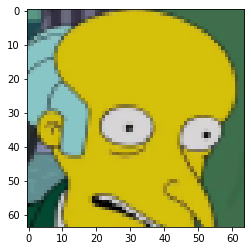

In [ ]:

dim = (64, 64)

saved_imgs = '/content/simpsons_images/images - Copy.npy'
print('reloading images')

images = np.load(saved_imgs)
print('dataset shape:', images.shape)




X = images.astype('float32') / 255.0
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

plt.imshow(X_train[0])

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16384)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3,strides=(2,2), activation="relu",  padding="same")(x)
x = layers.Conv2DTranspose(32, 3,strides=(2,2), activation="relu",  padding="same")(x)
x = layers.Conv2DTranspose(16, 3,strides=(2,2), activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              12288     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 3)         435 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [ ]:
simps = np.concatenate([X_train, X_test], axis=0).astype("float32") 

In [ ]:
print(simps[0].min())
print(simps[0].max())

0.0
0.8627451


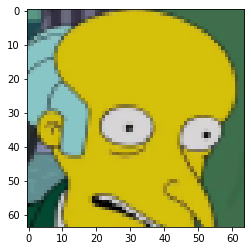

In [ ]:
simps.shape

plt.imshow(simps[0])

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(simps, epochs=80, batch_size=128)

Epoch 1/80
71/71 [==============================] - 2s 23ms/step - loss: 484.5042 - reconstruction_loss: 482.6943 - kl_loss: 1.8099
Epoch 2/80
71/71 [==============================] - 2s 23ms/step - loss: 480.3996 - reconstruction_loss: 478.4557 - kl_loss: 1.9440
Epoch 3/80
71/71 [==============================] - 2s 22ms/step - loss: 480.3874 - reconstruction_loss: 478.4408 - kl_loss: 1.9465
Epoch 4/80
71/71 [==============================] - 2s 22ms/step - loss: 480.2865 - reconstruction_loss: 478.3305 - kl_loss: 1.9560
Epoch 5/80
71/71 [==============================] - 2s 23ms/step - loss: 480.4267 - reconstruction_loss: 478.4623 - kl_loss: 1.9644
Epoch 6/80
71/71 [==============================] - 2s 22ms/step - loss: 480.2124 - reconstruction_loss: 478.2217 - kl_loss: 1.9908
Epoch 7/80
71/71 [==============================] - 2s 22ms/step - loss: 480.0974 - reconstruction_loss: 478.0966 - kl_loss: 2.0008
Epoch 8/80
71/71 [==============================] - 2s 22ms/step - loss: 480

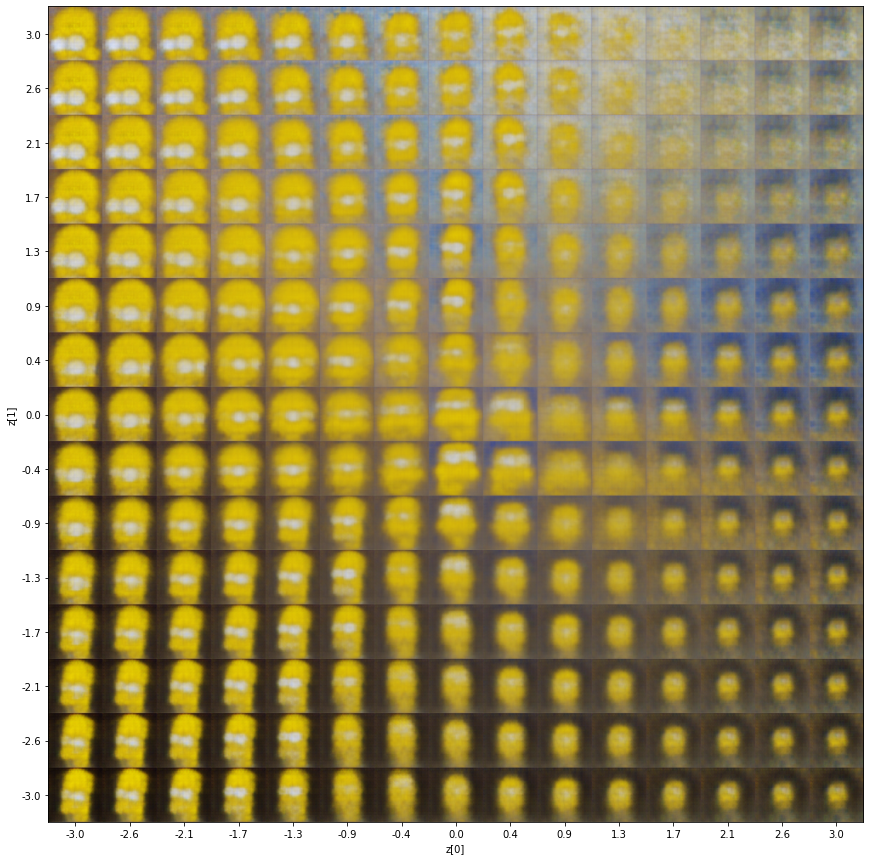

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 15
    digit_size = 64
    scale = 3.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,3)
            # print('digit.shape:',digit.shape)
            # print('digit.min():',digit.min())
            # print('digit.max():',digit.max())
            # plt.imshow(digit)
            # plt.show()
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)#, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)